Load the libraries

In [1]:
import pandas as pd
import scipy.stats
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import funcs as ff #utilities leo
from VAE import VAE #classe Variational AutoEncoder leo

tf.random.set_seed(42)
autotune = tf.data.experimental.AUTOTUNE
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

# Data Loading and preprocessing

In [2]:

'''
DIRECTORIES
'''
cwd = '/Volumes/Seagate Backup Plus Drive/EXPERIMENTS' #os.getcwd()

serie_dir = os.path.join(cwd, 'Embeddings/vae200')
if not os.path.isdir(serie_dir):
    raise ValueError('non c\'è la cartella asino')

datasets_dir = '/Volumes/Seagate Backup Plus Drive/datasets/vae200'
if not os.path.isdir(datasets_dir):
    raise ValueError('non c\'è la cartella asino')

train_dir = os.path.join(datasets_dir, 'train')
test_dir = os.path.join(datasets_dir, 'test')


model_names = None
for it, (root, dirs, files) in enumerate(os.walk(serie_dir)):
    print('level : {}\nroot : {}'.format(it, root))
    print('files')
    for name in files:
        print(name)
    print('dirs')
    for name in dirs:
        print(name)
    model_names = dirs
    break


datasets_val = []
datasets_test = []

for root, dirs, files in os.walk(train_dir):
    print('files')
    for name in files:
        print(name)
        datasets_val.append(os.path.join(root, name))
    break

for root, dirs, files in os.walk(test_dir):
    print('files')
    for name in files:
        print(name)
        datasets_test.append(os.path.join(root, name))
    break

print(datasets_val)
print('cwd : ', cwd)
print('serie dir : ', serie_dir)

level : 0
root : /Volumes/Seagate Backup Plus Drive/EXPERIMENTS/Embeddings/vae200
files
.DS_Store
Averaged_predictions-Extremely Randomized Trees-Auroc.png
Averaged_predictions-Gradient Boosting-Auroc.png
Averaged_predictions-Random Forest-Auroc.png
DenseNet121-vae200-Extremely Randomized Trees-Auroc.png
DenseNet121-vae200-Gradient Boosting-Auroc.png
DenseNet121-vae200-KNN-Auroc.png
DenseNet121-vae200-Random Forest-Auroc.png
DenseNet169-vae200-Extremely Randomized Trees-Auroc.png
DenseNet169-vae200-Gradient Boosting-Auroc.png
DenseNet169-vae200-KNN-Auroc.png
DenseNet169-vae200-Random Forest-Auroc.png
DenseNet201-vae200-Extremely Randomized Trees-Auroc.png
DenseNet201-vae200-Gradient Boosting-Auroc.png
DenseNet201-vae200-KNN-Auroc.png
DenseNet201-vae200-Random Forest-Auroc.png
Entropy_averaged_predictions-Extremely Randomized Trees-Auroc.png
Entropy_averaged_predictions-Gradient Boosting-Auroc.png
Entropy_averaged_predictions-Random Forest-Auroc.png
InceptionResNet-vae200-Extremely Rand

In [3]:
### dataset con val e test (val per training di embeddings) quello originale 12
label_length=14
z_dimension = 200

def record_parser(example):
    example_fmt = {'label': tf.io.FixedLenFeature([label_length], tf.float32),
        'z_mean': tf.io.FixedLenFeature([z_dimension], tf.float32),
        'z_logsigma': tf.io.FixedLenFeature([z_dimension], tf.float32)
    }
    parsed = tf.io.parse_single_example(example, example_fmt)
    
    return parsed["label"], parsed["z_mean"], parsed["z_logsigma"]

def make_2d(label, z_mean, z_logsigma):
    return label[0], z_mean[0], z_logsigma[0]

def make_tfDataset(full_path, batch_size=1):
    dataset = tf.data.TFRecordDataset(full_path)
    parsed_dataset = dataset.map(record_parser,num_parallel_calls = autotune).batch(batch_size, drop_remainder=True).prefetch(1)
    parsed_dataset = parsed_dataset.map(make_2d)
    return parsed_dataset


dss_val = []
dss_test = []
for ds_val, ds_test in zip(datasets_val, datasets_test):
    dss_val.append(make_tfDataset(ds_val))
    dss_test.append(make_tfDataset(ds_test))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [4]:
chexpert_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
label_mask=[chexpert_labels[i] in target_labels for i, _ in enumerate(chexpert_labels)]

In [5]:
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
#fig, c_ax = plt.subplots(2,3, figsize = (15, 10))

# Stacking

In [6]:
'''
def build_meta_learner_dataset(models,dataset):
  for model in models: 
    predictions.append(model.predict(dataset))
  predictions = np.array(predictions)
  new_pred = []
  for i in range(predictions.shape[1]):
    new_pred.append(predictions[:,i])
  new_pred = np.array(new_pred)
  X = new_pred.reshape((new_pred.shape[0],-1))

  unbatched_dataset = dataset.unbatch()
  Y = []
  for _, labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y)
  return X , Y
'''

'\ndef build_meta_learner_dataset(models,dataset):\n  for model in models: \n    predictions.append(model.predict(dataset))\n  predictions = np.array(predictions)\n  new_pred = []\n  for i in range(predictions.shape[1]):\n    new_pred.append(predictions[:,i])\n  new_pred = np.array(new_pred)\n  X = new_pred.reshape((new_pred.shape[0],-1))\n\n  unbatched_dataset = dataset.unbatch()\n  Y = []\n  for _, labels in unbatched_dataset:\n    Y.append(labels.numpy())\n  Y = np.array(Y)\n  return X , Y\n'

# Embedding

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.multioutput import MultiOutputClassifier
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


### Grid-search CV for tuning

In [8]:
### ML models

random_seed=0
n_estimators=100
def finetune_cv(data, labels, param_grid, model):
  cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
  grid = GridSearchCV(model, param_grid, cv=cv, verbose=1, scoring="roc_auc", n_jobs=-1)
  grid.fit(data,labels)
  print("best estimator:")
  print(grid.best_estimator_)
  best_model = grid.best_estimator_
  return best_model
# Number of trees in random forest
param_grid_xrt = {'n_estimators': [10, 50, 100],
                 'criterion': ["gini", "entropy"],
              'max_depth': [2,5,10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'random_state': [0], 
              'n_jobs':[-1]}
param_grid_rf = {'n_estimators': [750, 1000, 1250, 1500],
                 'criterion': ["gini", "entropy"],
              'max_depth': [9, 10, 11],
              'min_samples_split': [10, 12, 15],
              'min_samples_leaf': [4],
              'bootstrap': [True, False],
              'random_state': [0]}

param_grid_KNN = {'n_neighbors': [10, 13, 15, 20],
                  'p': [1,2], 
                  'n_jobs':[-1]}
'''
ML_models = {'Decision Tree':DecisionTreeClassifier(max_depth=10,
														random_state=random_seed),
					'Random Forest':finetune_cv(x, y.astype(int), param_grid_rf, RandomForestClassifier()),
					'Extremely Randomized Trees':finetune_cv(x, y.astype(int), param_grid_xrt, ExtraTreesClassifier()),
					'KNN': finetune_cv(x, y.astype(int), param_grid_KNN, KNeighborsClassifier())
				}
'''

"\nML_models = {'Decision Tree':DecisionTreeClassifier(max_depth=10,\n\t\t\t\t\t\t\t\t\t\t\t\t\t\trandom_state=random_seed),\n\t\t\t\t\t'Random Forest':finetune_cv(x, y.astype(int), param_grid_rf, RandomForestClassifier()),\n\t\t\t\t\t'Extremely Randomized Trees':finetune_cv(x, y.astype(int), param_grid_xrt, ExtraTreesClassifier()),\n\t\t\t\t\t'KNN': finetune_cv(x, y.astype(int), param_grid_KNN, KNeighborsClassifier())\n\t\t\t\t}\n"

In [9]:
'''
'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                                                max_depth=10, max_features=None, max_leaf_nodes=None,
                                                min_impurity_decrease=0.0, min_impurity_split=None,
                                                min_samples_leaf=1, min_samples_split=2,
                                                min_weight_fraction_leaf=0.0, random_state=0, splitter='best'),
'''


def create_ml_models_dict():


    ML_MODELS = {
        'Gradient Boosting' : MultiOutputClassifier(GradientBoostingClassifier(n_estimators=1000, learning_rate=0.5), n_jobs=-1),
        'Extremely Randomized Trees': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                                                           criterion='entropy', max_depth=10, max_features='auto',
                                                           max_leaf_nodes=None, max_samples=None,
                                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                                           min_samples_leaf=2, min_samples_split=2,
                                                           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                                                           oob_score=False, random_state=0, verbose=0,
                                                           warm_start=False),
        'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                    metric_params=None, n_jobs=-1, n_neighbors=10, p=1,
                                    weights='uniform'),
        'Random Forest': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                                criterion='entropy', max_depth=10, max_features='sqrt',
                                                max_leaf_nodes=None, max_samples=None,
                                                min_impurity_decrease=0.0, min_impurity_split=None,
                                                min_samples_leaf=1, min_samples_split=5,
                                                min_weight_fraction_leaf=0.0, n_estimators=2000,
                                                n_jobs=-1, oob_score=False, random_state=None,
                                                verbose=0, warm_start=False)
    }
    return ML_MODELS

In [10]:
def train_clf(clf, x, y, name = None):
    if name is None:
        name = 'clf'
    start_time = time.time()
    clf.fit(x, y.astype(int))
    print('time to train {} : {}'.format(name, time.time()-start_time))

    return clf

def test_clf(clf, x, y, title, savename):
    fig, ax = plt.subplots(1,1, figsize = (15, 15))
    aurocs = []
    predictions = clf.predict_proba(x)
    #print('{} prediction 0 : {}'.format(title, predictions[0]))
    prob_pred = np.array(predictions)[:,:,1].T
    for i, label in enumerate(chexpert_labels):
        if label_mask[i]:
            fpr, tpr, thresholds = roc_curve(y[:,i].astype(int), prob_pred[:,i])
            #ax = fig.add_subplot(2,3,j)
            ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
            aurocs.append(auc(fpr, tpr))
            ax.legend()
            ax.set_xlabel('False Positive Rate', color='red')
            ax.set_ylabel('True Positive Rate', color='red')
            ax.set_title('{}AUROC: {:0.4f}'.format(title, np.mean(aurocs)), color='red')
    plt.savefig(savename+'-Auroc')
    return prob_pred

def test_preds(preds, y, title, savename):
    fig, ax = plt.subplots(1,1, figsize = (15, 15))
    aurocs = []
    for i, label in enumerate(chexpert_labels):
        if label_mask[i]:
            fpr, tpr, thresholds = roc_curve(y[:,i].astype(int), preds[:,i])
            #ax = fig.add_subplot(2,3,j)
            ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
            aurocs.append(auc(fpr, tpr))
            ax.legend()
            ax.set_xlabel('False Positive Rate', color='red')
            ax.set_ylabel('True Positive Rate', color='red')
            ax.set_title('{}AUROC: {:0.4f}'.format(title, np.mean(aurocs)), color='red')
    plt.savefig(savename+'-Auroc')
    return aurocs

def split_tfrecord_ds(ds):
    l = []
    zm = []
    zls = []
    for label, z_mean, z_logsigma in ds:
        l.append(label.numpy())
        zm.append(z_mean.numpy())
        zls.append(z_logsigma.numpy())

    x = np.array(zm)
    y = np.array(l)

    return x, y

def average_columns(df: pd.DataFrame, weights_df = None, axis = 0):
    """
    The dataframe with the prediction is built as follows :
    # |  DL-model    |  ML-preds1                |  ML-preds2                | ...
    # -----------------------------------------------------------------------------
    1 |  'dl-name1'  | [[14prob1],[14prob2],...] | [[14prob1],[14prob2],...] | ...
    2 |  'dl-name2'  | [[14prob1],[14prob2],...] | [[14prob1],[14prob2],...] | ...
    3 |  'dl-name3'  | [[14prob1],[14prob2],...] | [[14prob1],[14prob2],...] | ...
    4 |       .      |           .               |           .               | ...
    5 |       .      |           .               |           .               | ...
    6 |       .      |           .               |           .               | ...
    this function averages the predictions over the specified axis, being it either 0 (so,
    dl model-wise) or 1 (meaning ML-model-wise). It returns the averaged predictions. Weights,
    such as entropy, can be included
    """
    dict = {}
    for colname in df:
        if colname == 'Extremely Randomized Trees' or colname == 'Random Forest' or colname == 'Gradient Boosting':
            vals = None
            for row in range(df.shape[0]):
                # to concatenate keeping the arrays separated i have to add the first dim
                single_val = np.expand_dims(pred_dataframe.at[row, colname], axis=0)
                print('single val shape : {}'.format(single_val.shape))
                vals = np.concatenate([vals, single_val], axis=0) if vals is not None else single_val
                wgts = None
            if weights_df is not None:
                wgts = 1 - np.array(weights_df.at[weights_df.index[0], colname])
                print('wgts shape : {}'.format(wgts.shape))
                print('vals shape : {}'.format(vals.shape))
            averaged_vals = np.average(vals, axis=axis, weights=wgts)
            dict[colname] = [averaged_vals]
    final_df = pd.DataFrame(dict)
    return final_df

def compute_entropy(df : pd.DataFrame):
    dict = {}
    for colname in df:
        if colname == 'Extremely Randomized Trees' or colname == 'Random Forest' or colname == 'Gradient Boosting':
            vals = None
            for row in range(df.shape[0]):
                # to concatenate keeping the arrays separated i have to add the first dim
                tmppreds = pred_dataframe.at[row, colname]
                entropy = np.array(scipy.stats.entropy([tmppreds, 1-tmppreds], base=2))
                #entropy = -np.sum(tmppreds*np.log2(tmppreds)) #entropy formula as per scipy doc
                #entropy = np.sum(scipy.special.entr(1-tmppreds))/np.log(2)
                single_val = np.expand_dims(entropy, axis=0)
                vals = np.concatenate([vals, single_val], axis=0) if vals is not None else single_val
            print('entropy vals : {}'.format(vals.shape))
            dict[colname] = [vals]
    final_df = pd.DataFrame(dict)
    return final_df


In [11]:
dct = {'model' : model_names}
tmp = create_ml_models_dict()
for key in tmp.keys():
    dct[key] = [np.zeros(14) for a in model_names]
pred_dataframe = pd.DataFrame(dct)
#print(pred_dataframe)

2021-08-02 14:52:36.443391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-02 14:52:36.443491: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


(1911, 200) (1911, 14)
time to train Gradient Boosting : 199.69000792503357
time to train Extremely Randomized Trees : 0.37003207206726074
time to train KNN : 0.0009539127349853516
time to train Random Forest : 23.60223698616028
(1911, 200) (1911, 14)
time to train Gradient Boosting : 197.47938299179077
time to train Extremely Randomized Trees : 0.4655888080596924
time to train KNN : 0.0013530254364013672
time to train Random Forest : 22.710062980651855
(1911, 200) (1911, 14)
time to train Gradient Boosting : 196.84559202194214
time to train Extremely Randomized Trees : 0.46202898025512695
time to train KNN : 0.0009682178497314453
time to train Random Forest : 23.833979845046997
(1911, 200) (1911, 14)
time to train Gradient Boosting : 197.5531039237976
time to train Extremely Randomized Trees : 0.4606006145477295
time to train KNN : 0.001728057861328125
time to train Random Forest : 24.052361249923706
(1911, 200) (1911, 14)
time to train Gradient Boosting : 198.5018548965454
time to tr

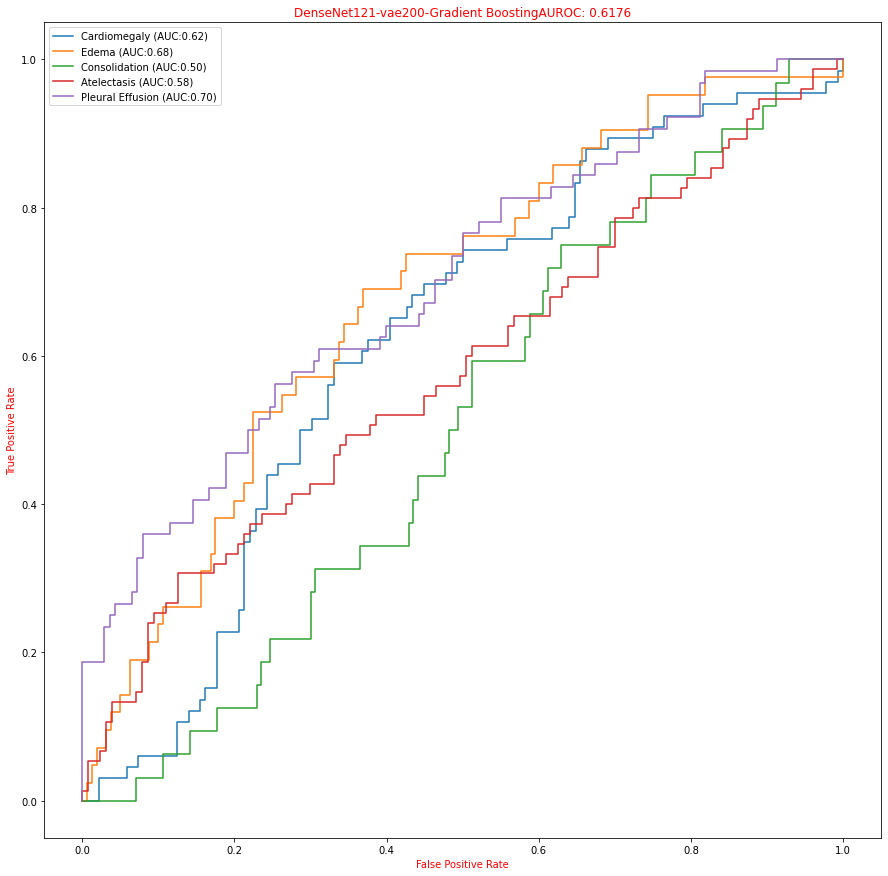

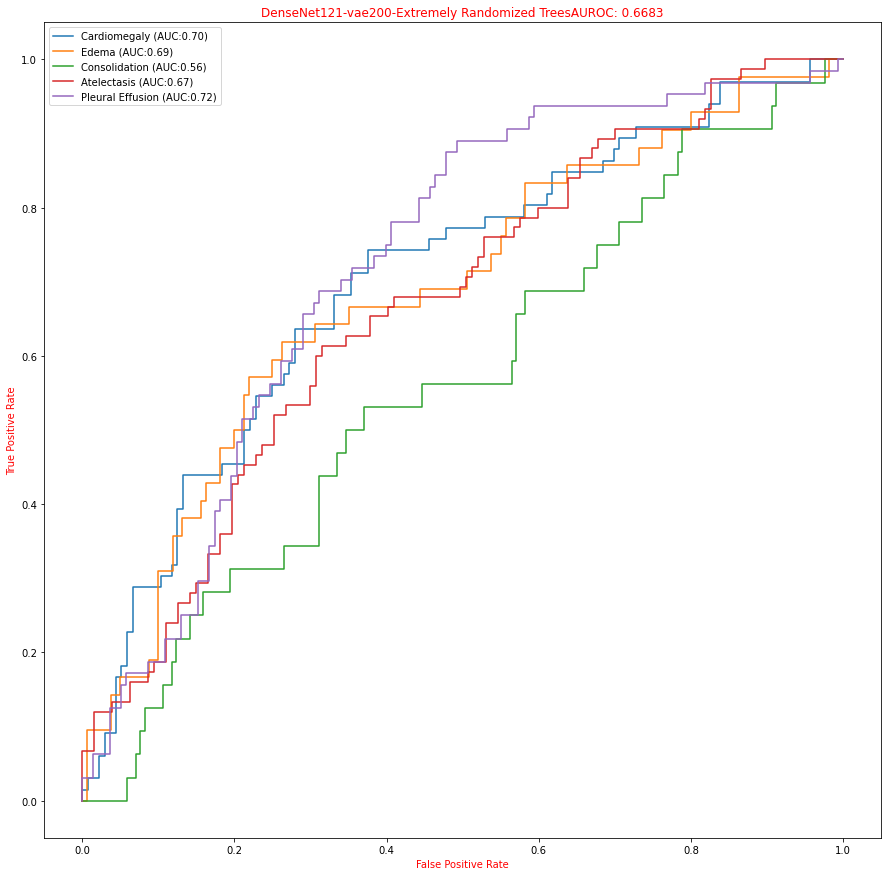

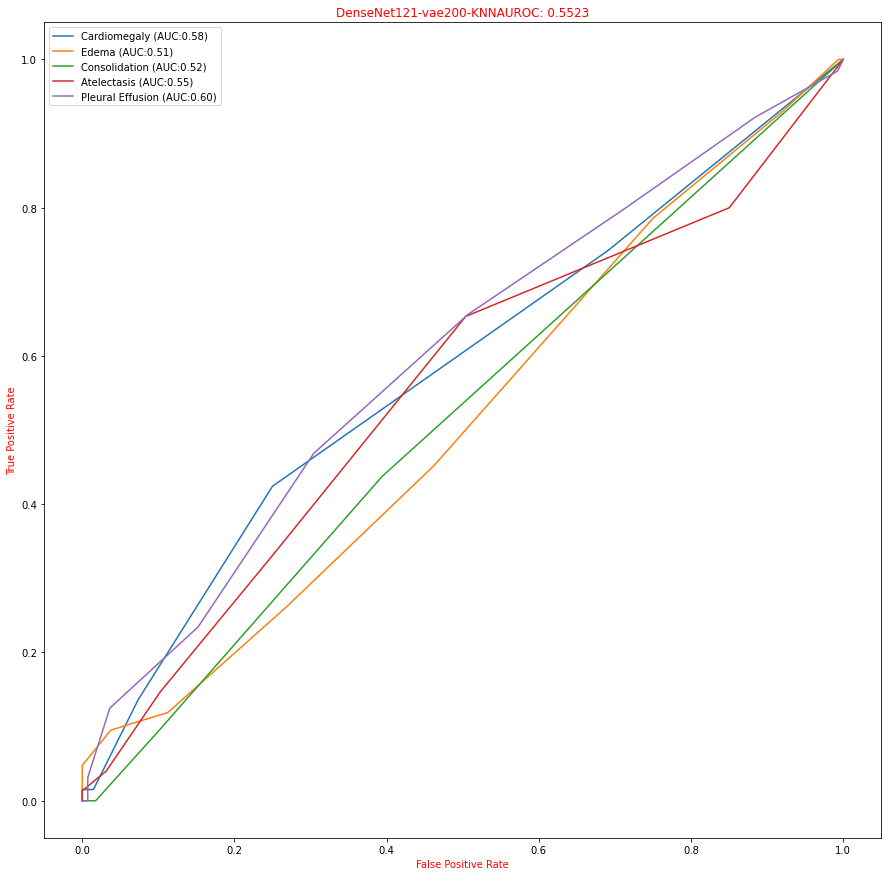

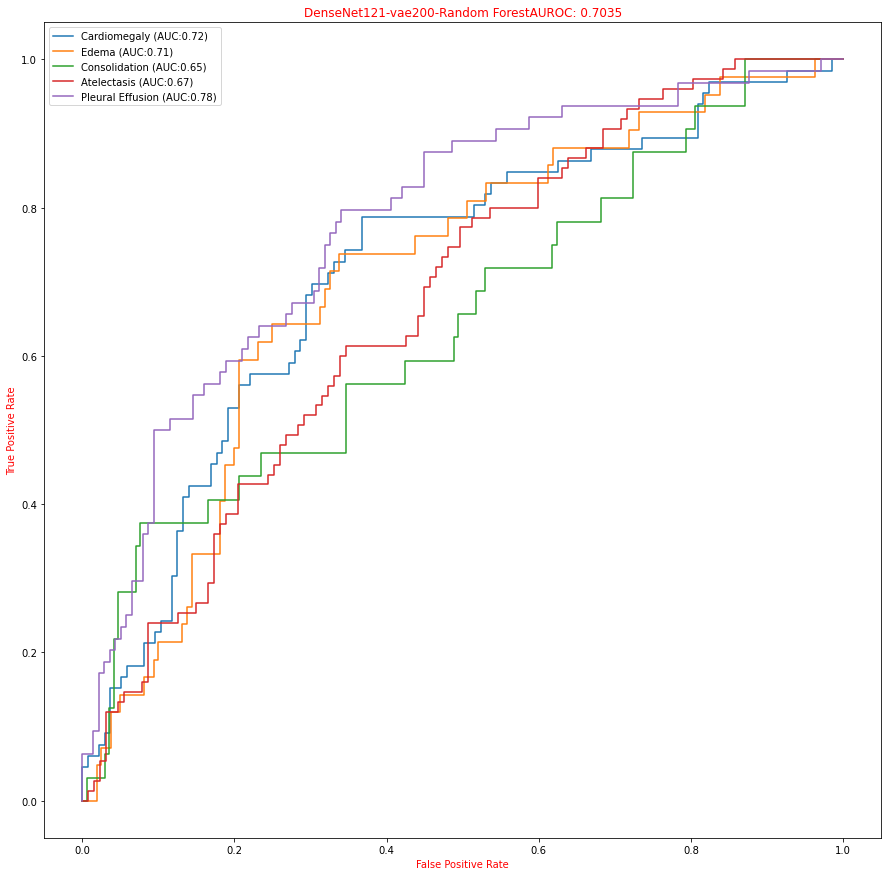

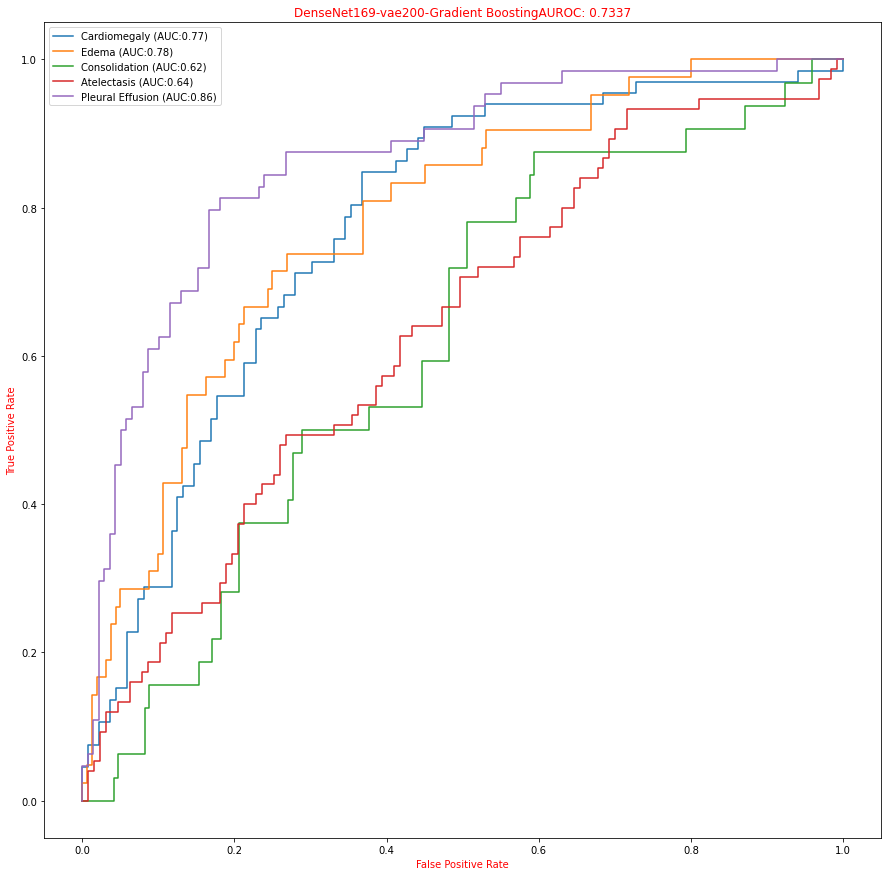

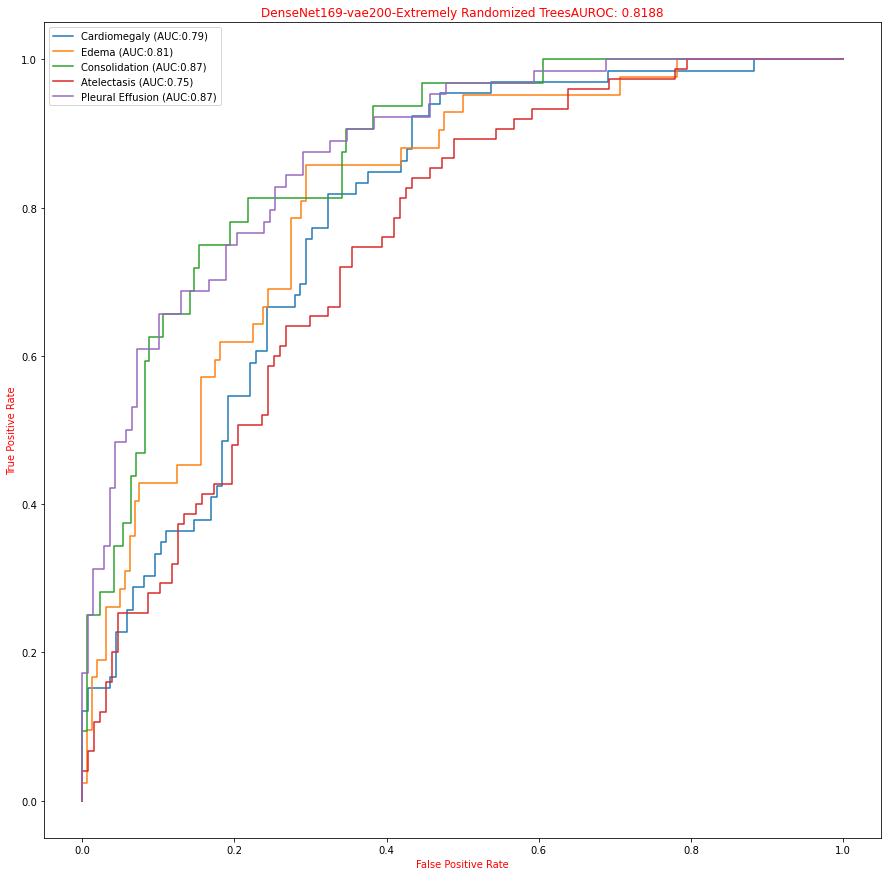

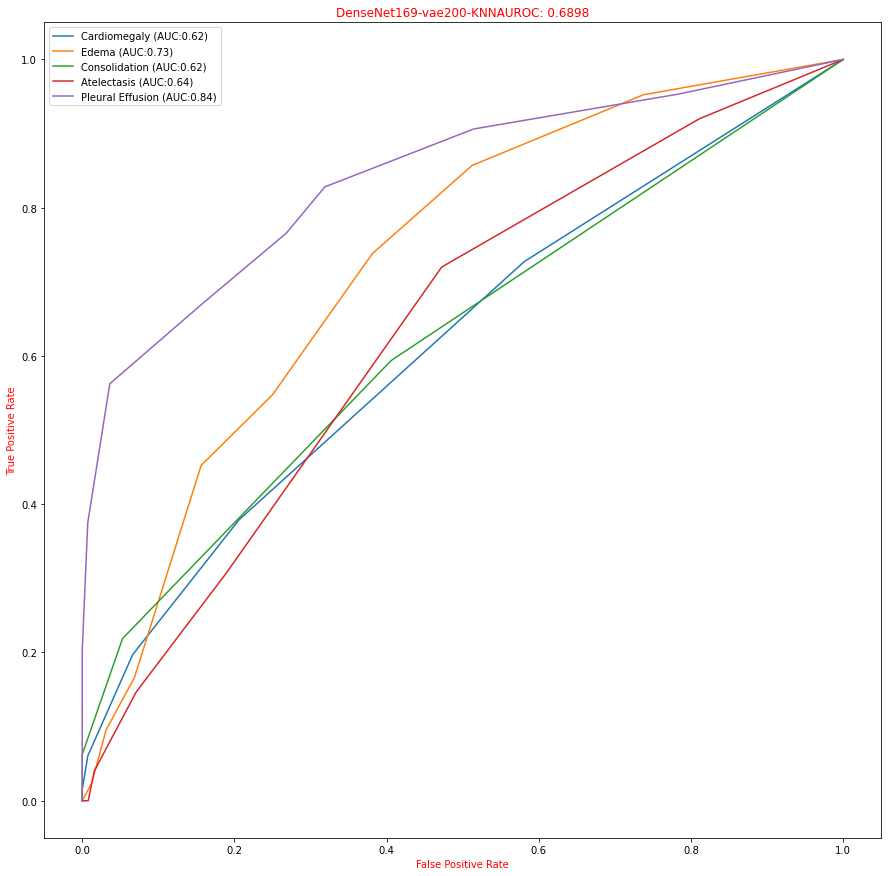

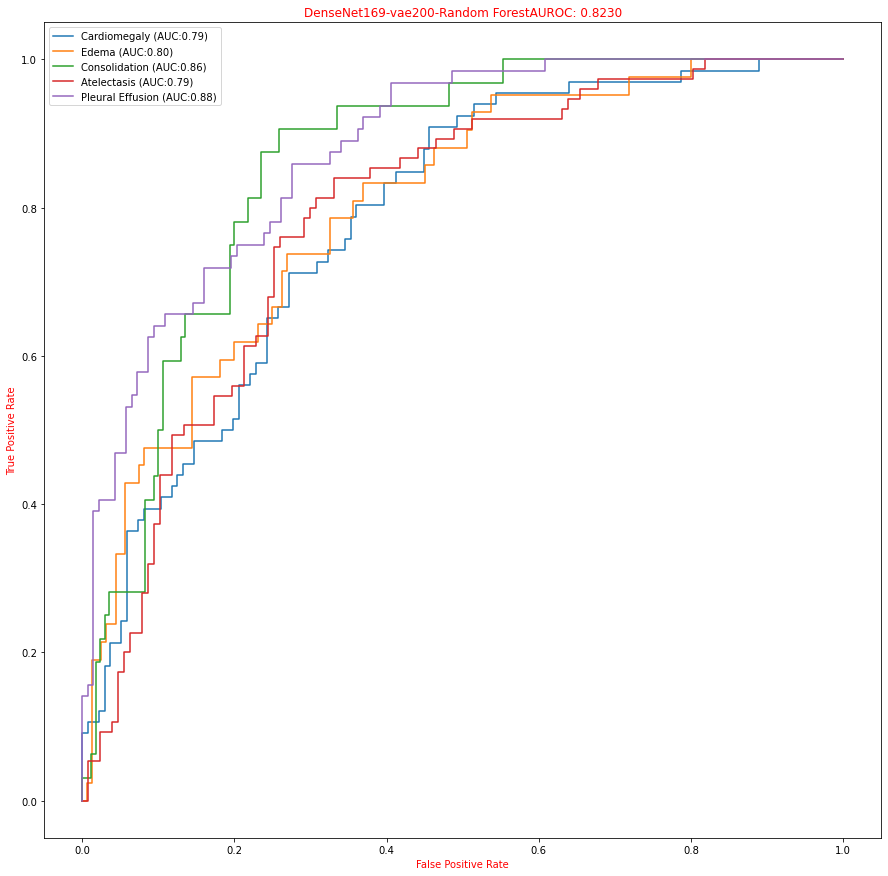

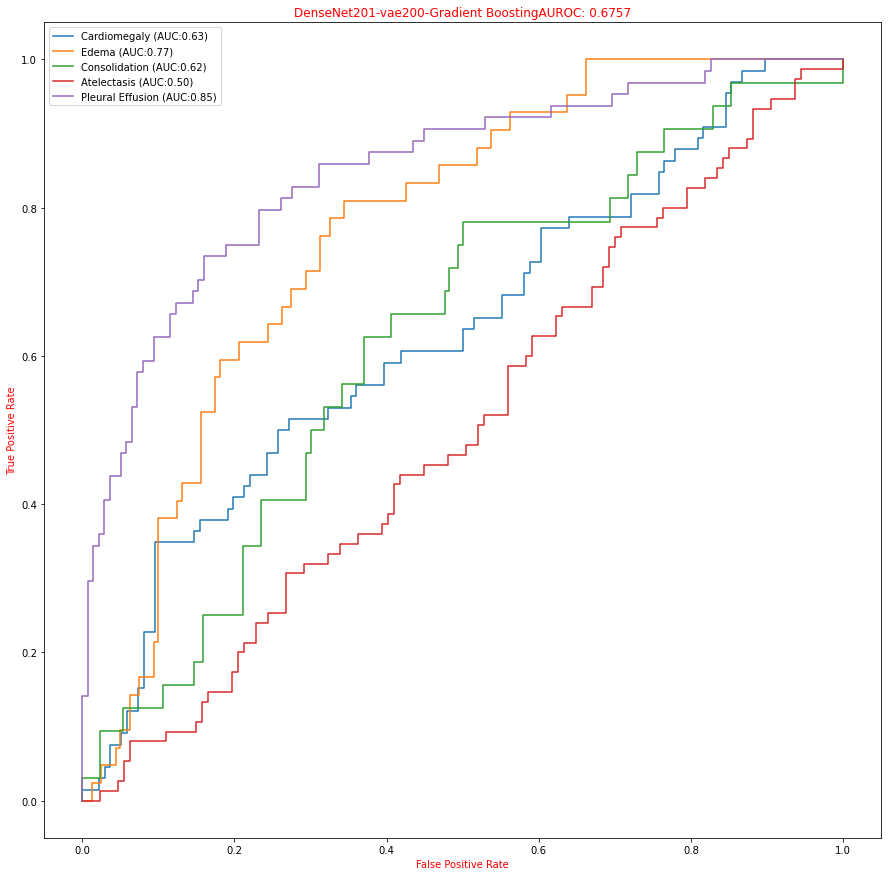

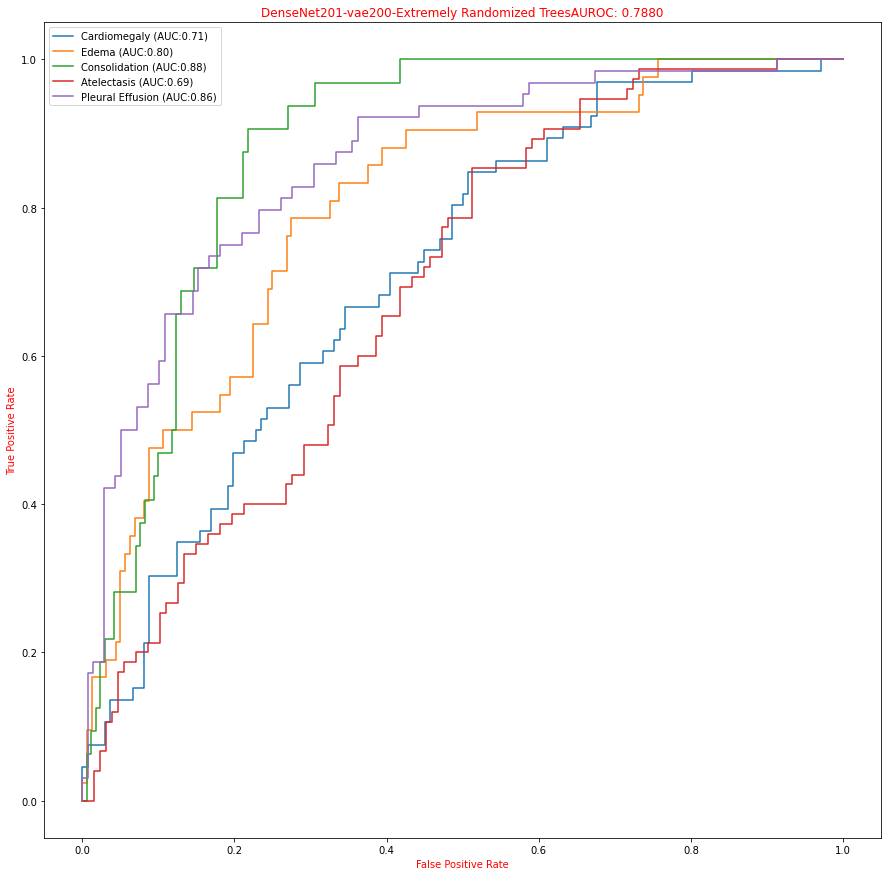

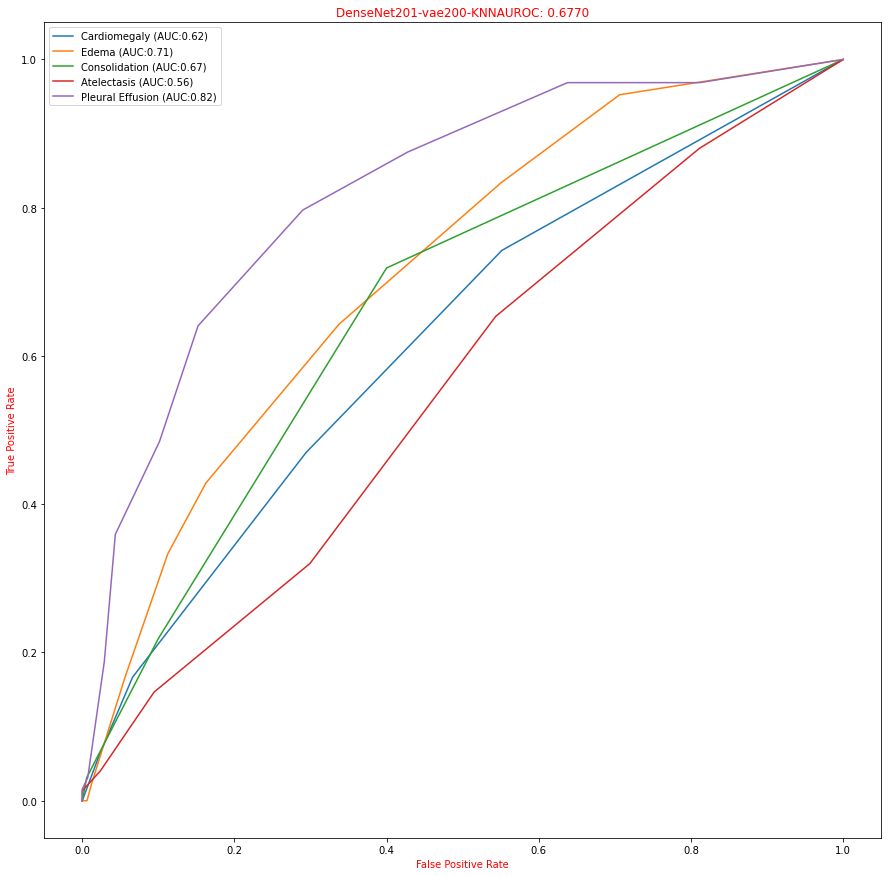

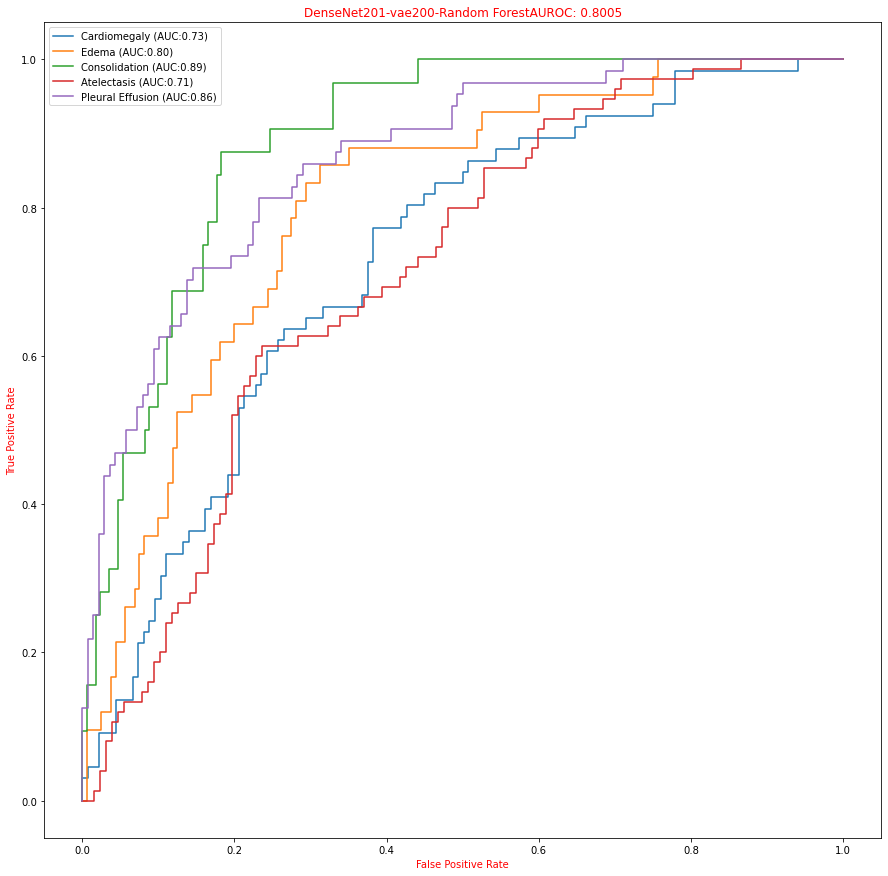

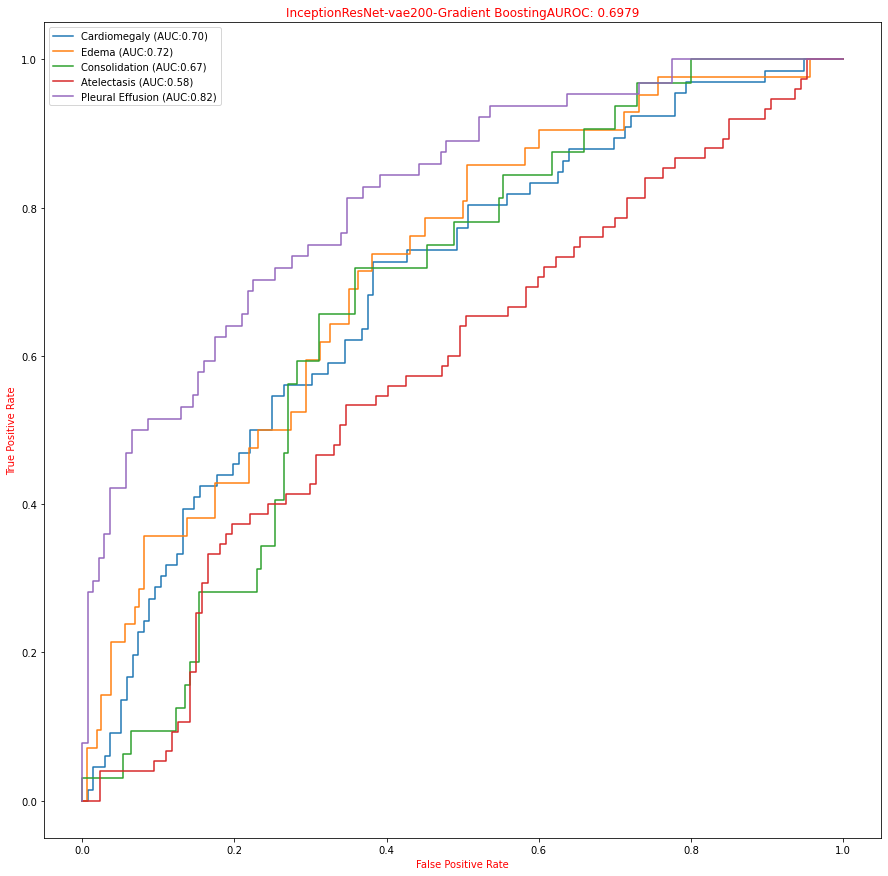

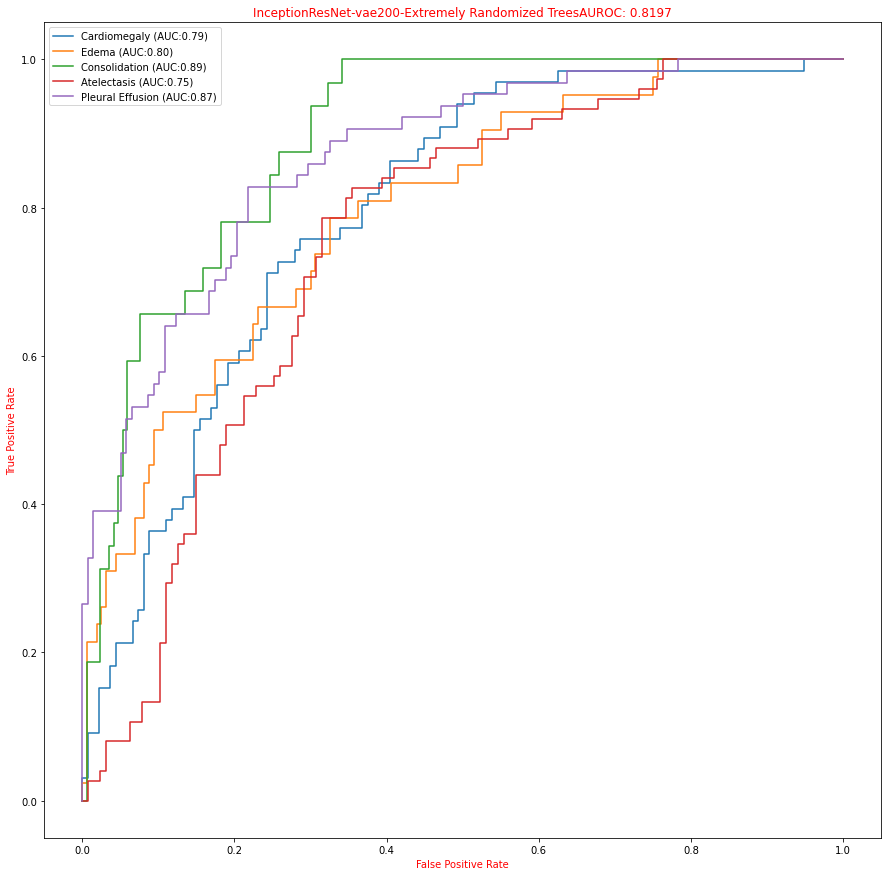

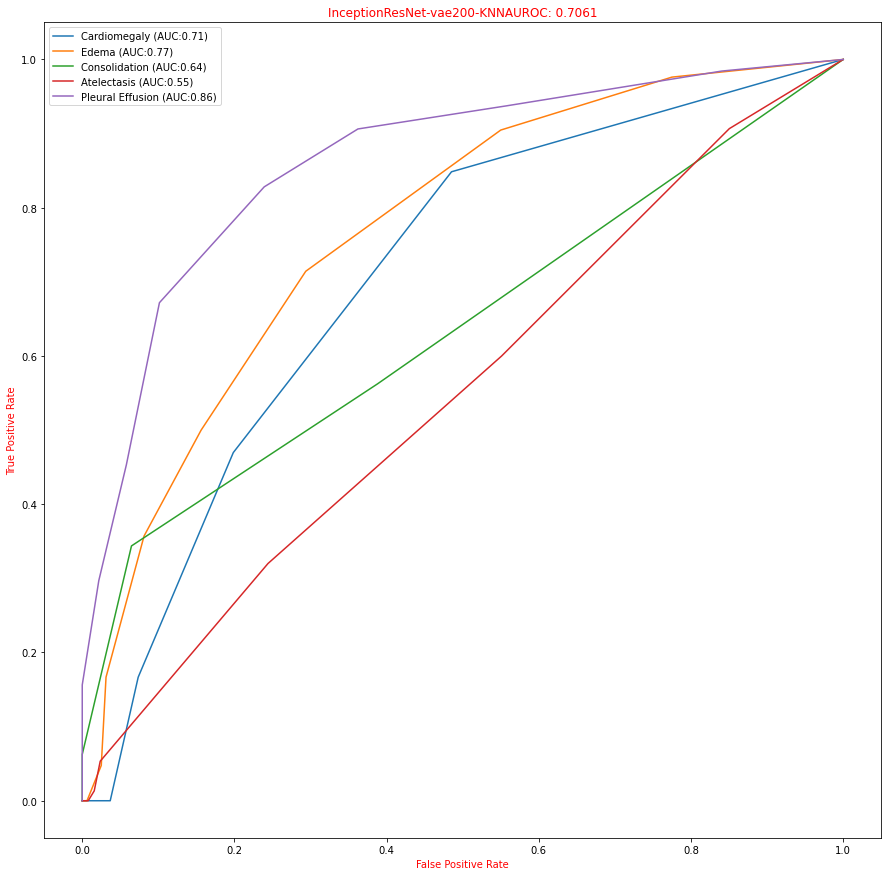

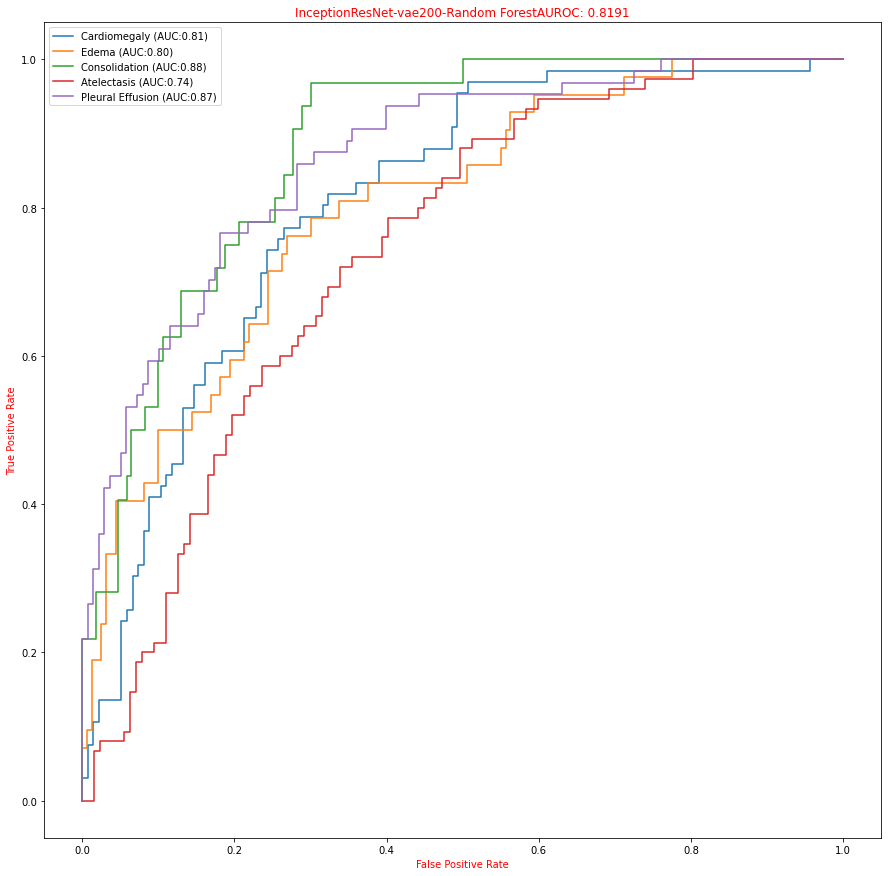

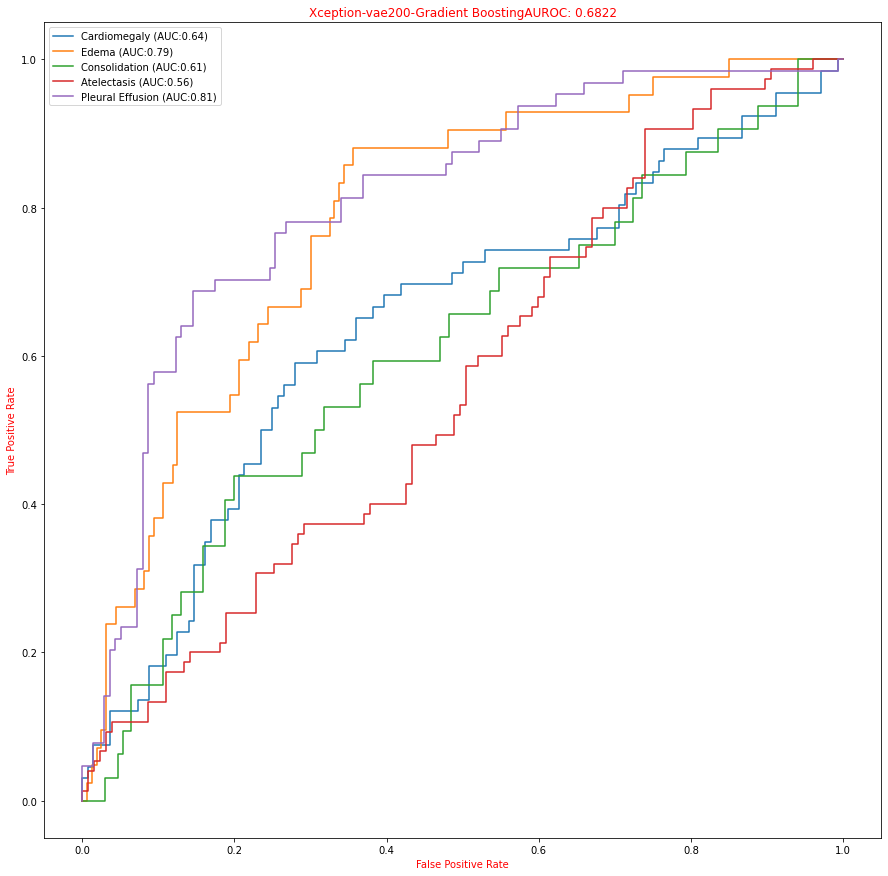

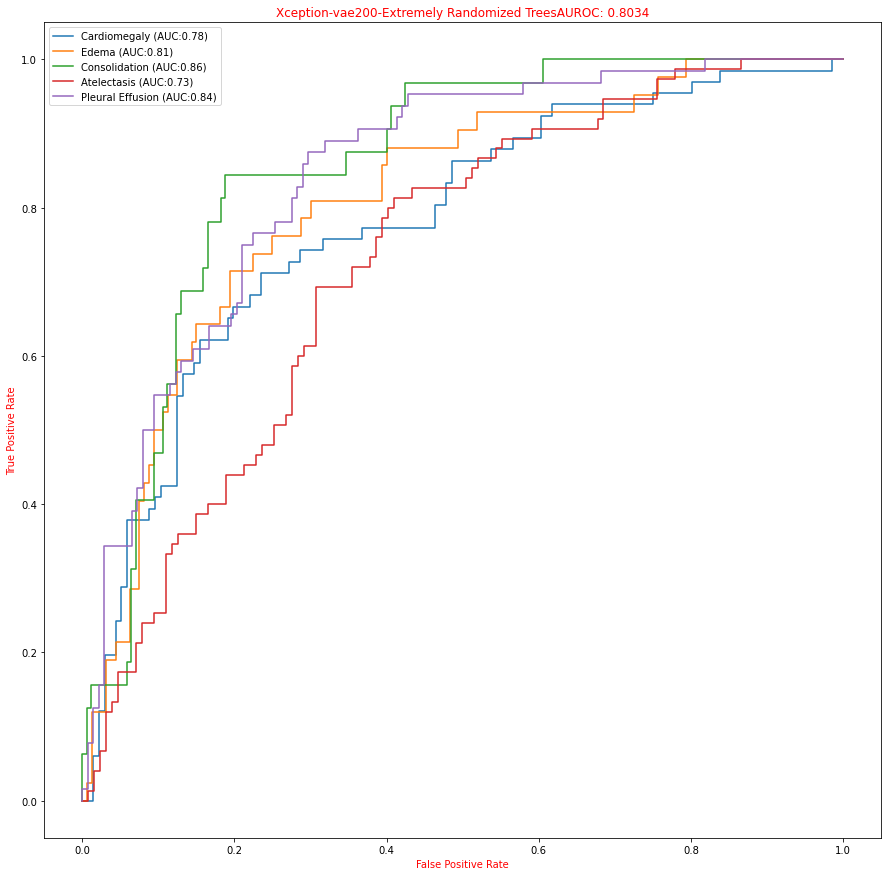

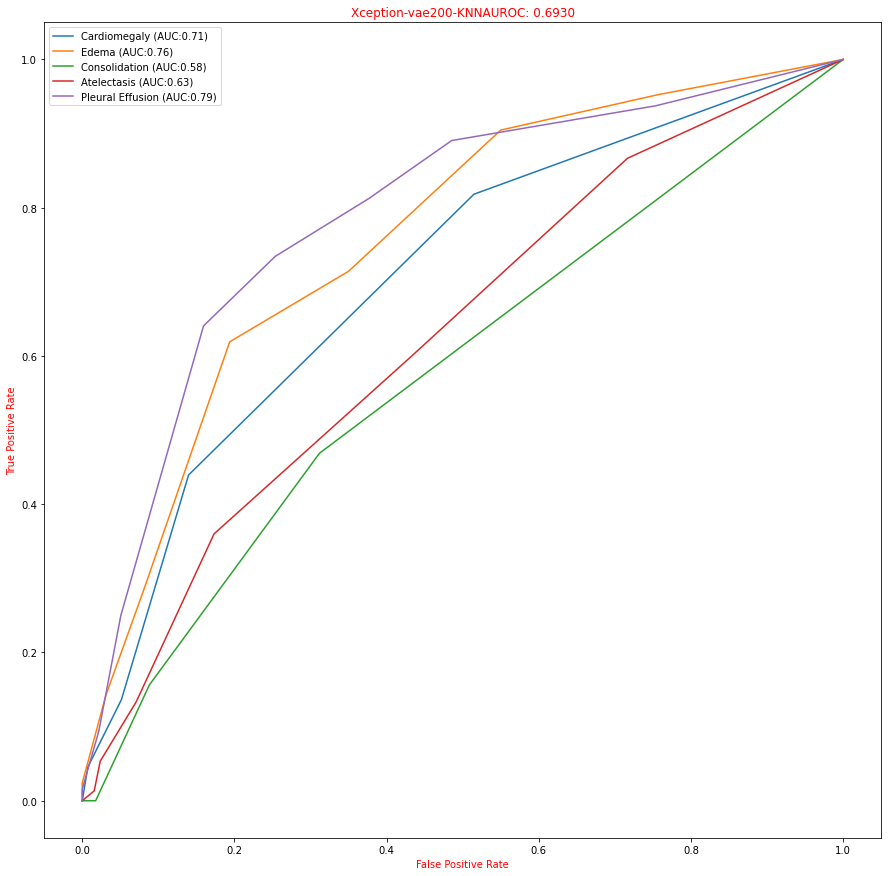

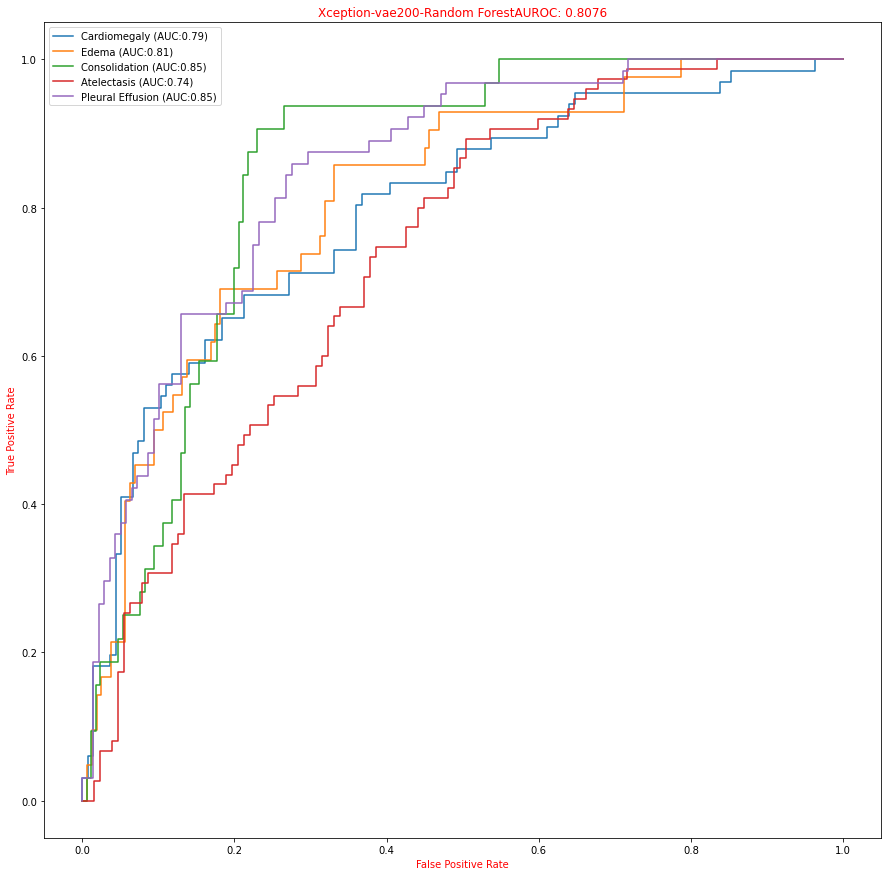

In [12]:
it = 0
for val, test in zip(dss_val, dss_test):
    x, y = split_tfrecord_ds(val)
    print(x.shape, y.shape)
    xt, yt = split_tfrecord_ds(test)
    dict = create_ml_models_dict()
    for key, model in zip(list(dict.keys()), list(dict.values())):
        clf = train_clf(model, x, y, key)
        title = model_names[it] + '-' + key
        savepath = os.path.join(serie_dir, title)
        preds = test_clf(clf, xt, yt, title, savepath)
        #print('{} preds shape : {}'.format(key, preds.shape))
        pred_dataframe.at[it, key] = preds
        #print('{} preds shape from df : {}'.format(key, pred_dataframe.at[it, key].shape))
    it +=1
#print(pred_dataframe)

In [13]:
averaged_df = average_columns(pred_dataframe, axis=1)
entropy_df = compute_entropy(pred_dataframe)
print(entropy_df.at[0, 'Random Forest'].shape)
entropy_averaged_df = average_columns(pred_dataframe, entropy_df, axis=1)

single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
entropy vals : (5, 202, 14)
entropy vals : (5, 202, 14)
entropy vals : (5, 202, 14)
(5, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
wgts shape : (5, 202, 14)
vals shape : (5, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
single val shape : (1, 202, 14)
wgts shape : (5, 202, 14)
vals shape : (5, 202, 14)

ValueError: Found input variables with inconsistent numbers of samples: [202, 5]

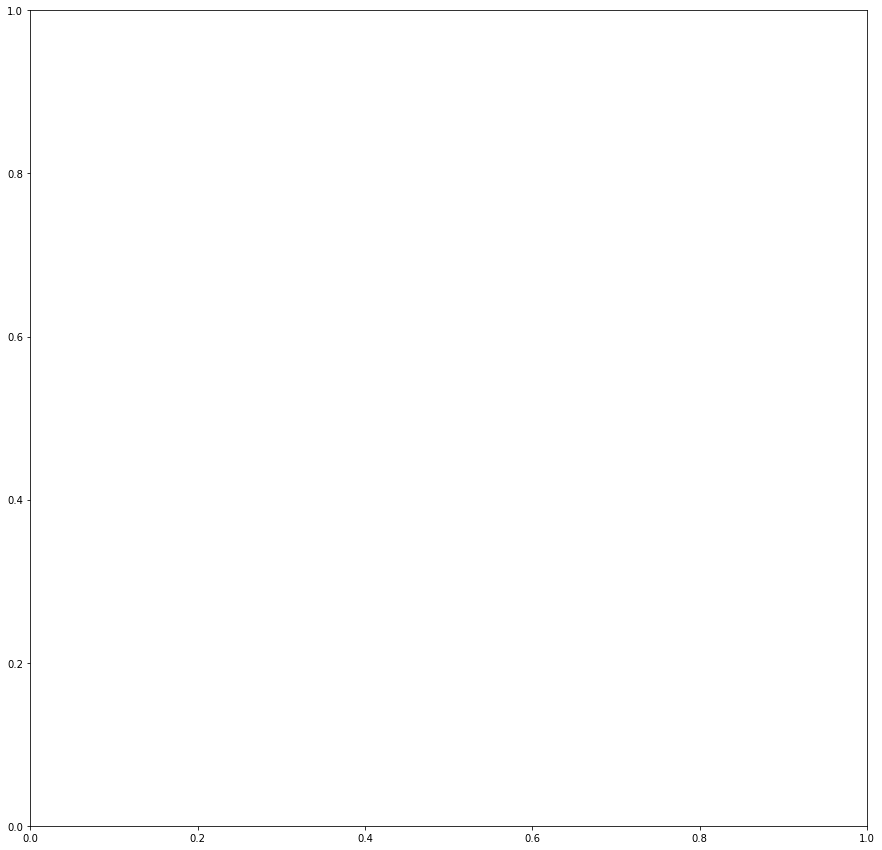

In [14]:
# test labels (equal in each test ds, even though the test data differs wtr to each dl model)
xt, yt = split_tfrecord_ds(dss_test[0])
for col in averaged_df:
    preds = averaged_df[col].to_numpy()[0]
    title = 'CNN-wise_Averaged_predictions-' + col
    savepath = os.path.join(serie_dir, title)
    aurocs = test_preds(preds, yt, title, savepath)
    for label, x in zip(target_labels, aurocs):
        print('{} - Average AUROCs {} : {}'.format(col, label, x))

for col in entropy_averaged_df:
    preds = entropy_averaged_df[col].to_numpy()[0]
    title = 'CNN-wise_Entropy_averaged_predictions-' + col
    savepath = os.path.join(serie_dir, title)
    aurocs = test_preds(preds, yt, title, savepath)
    for label, x in zip(target_labels, aurocs):
        print('{} - Entropy averaged AUROCs {} : {}'.format(col, label, x))

In [ ]:
#for col in pred_dataframe:
#data=pred_dataframe['Random Forest'].to_numpy()[0][np.random.randint(0, 200)]
#print(data)
#e1 = np.array(scipy.stats.entropy([data, 1-data], base=2))
#e3 = -np.sum(data*np.log2([data, 1-data]), axis=0) #entropy formula as per scipy doc
#e4 = np.sum(scipy.special.entr([data, 1-data]), axis=0)/np.log(2)
#e4
